In [ ]:
# Run in a Colab cell (prefix with !). If working locally, run in terminal without !
!pip install

 --quiet pandas numpy scikit-learn matplotlib seaborn xgboost lightgbm catboost imbalanced-learn shap joblib gradio streamlit


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# sklearn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# imbalanced-learn (SMOTE + pipeline)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# saving
import joblib

# interpretability
import shap

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [ ]:
# replace filename if different
DATA_PATH = "/content/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)
df.shape, df.head(3)


((7043, 21),
    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0  7590-VHVEG  Female              0     Yes         No       1           No   
 1  5575-GNVDE    Male              0      No         No      34          Yes   
 2  3668-QPYBK    Male              0      No         No       2          Yes   
 
       MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
 0  No phone service             DSL             No  ...               No   
 1                No             DSL            Yes  ...              Yes   
 2                No             DSL            Yes  ...               No   
 
   TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
 0          No          No              No  Month-to-month              Yes   
 1          No          No              No        One year               No   
 2          No          No              No  Month-to-month              Yes   
 
       PaymentMethod MonthlyCharg

In [ ]:
# Load the dataset from the uploaded file
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Basic info
print(df.info())
print("\nValue counts for target (Churn):")
print(df['Churn'].value_counts(dropna=False))
print("\nPercent churn:")
print(df['Churn'].value_counts(normalize=True))

# Drop duplicate or useless columns
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

# Fix TotalCharges: some rows may be blank strings -> coerce to NaN then convert to numeric
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Display missing
print("\nMissing values per column:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
# Fill numeric missing values with median as a quick fix
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='median')
if df['TotalCharges'].isnull().sum() > 0:
    df['TotalCharges'] = num_imputer.fit_transform(df[['TotalCharges']])


In [ ]:
# Map target to 0/1
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Separate features and target
X = df.drop(columns=['Churn'])
y = df['Churn']


In [ ]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),     # fill missing numeric values with median
    ('scaler', StandardScaler())                        # standardize numerics
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # fill missing categories with most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # convert categories to binary columns
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')  # drop any other columns

# quick test: fit preprocessor to X to see transformed shape (optional)
preprocessor.fit(X)
X_transformed = preprocessor.transform(X)
print("Transformed shape:", X_transformed.shape)

Transformed shape: (7043, 45)


In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_validate

# models to compare
models = [
    ('LR', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ('RF', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)),
    ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)),
    ('LightGBM', LGBMClassifier(random_state=RANDOM_STATE)),
    ('CatBoost', CatBoostClassifier(verbose=False, random_state=RANDOM_STATE))
]

scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []

for name, clf in models:
    # imblearn pipeline: preprocessor -> SMOTE -> classifier
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('clf', clf)
    ])

    print(f"Evaluating {name} ...")
    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    # compute mean of each metric
    metrics_mean = {metric: round(cv_results[f'test_{metric}'].mean(), 4) for metric in scoring}
    metrics_mean['Model'] = name
    results.append(metrics_mean)
    print(metrics_mean)


Evaluating LR ...
{'accuracy': np.float64(0.7498), 'precision': np.float64(0.5187), 'recall': np.float64(0.7967), 'f1': np.float64(0.6282), 'roc_auc': np.float64(0.8441), 'Model': 'LR'}
Evaluating KNN ...
{'accuracy': np.float64(0.6913), 'precision': np.float64(0.4499), 'recall': np.float64(0.7314), 'f1': np.float64(0.557), 'roc_auc': np.float64(0.7635), 'Model': 'KNN'}
Evaluating CART ...
{'accuracy': np.float64(0.7226), 'precision': np.float64(0.4799), 'recall': np.float64(0.5404), 'f1': np.float64(0.5081), 'roc_auc': np.float64(0.6642), 'Model': 'CART'}
Evaluating RF ...
{'accuracy': np.float64(0.7796), 'precision': np.float64(0.5889), 'recall': np.float64(0.5591), 'f1': np.float64(0.5733), 'roc_auc': np.float64(0.8195), 'Model': 'RF'}
Evaluating XGB ...
{'accuracy': np.float64(0.7784), 'precision': np.float64(0.5845), 'recall': np.float64(0.5687), 'f1': np.float64(0.5764), 'roc_auc': np.float64(0.8203), 'Model': 'XGB'}
Evaluating LightGBM ...
{'accuracy': np.float64(0.7852), 'preci

In [ ]:
results_df = pd.DataFrame(results).set_index('Model').sort_values('roc_auc', ascending=False)
results_df


,accuracy,precision,recall,f1,roc_auc
Model,,,,,
LR,0.7498,0.5187,0.7967,0.6282,0.8441
CatBoost,0.7923,0.6107,0.5982,0.6043,0.8371
LightGBM,0.7852,0.5950,0.5933,0.5941,0.8354
XGB,0.7784,0.5845,0.5687,0.5764,0.8203
RF,0.7796,0.5889,0.5591,0.5733,0.8195
KNN,0.6913,0.4499,0.7314,0.5570,0.7635
CART,0.7226,0.4799,0.5404,0.5081,0.6642


In [ ]:
# Example: choose XGBoost
best_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)

final_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf', best_clf)
])

# fit on ALL data (alternatively, fit on X_train only)
final_pipeline.fit(X, y)

# save pipeline
joblib.dump(final_pipeline, "churn_pipeline.pkl")
print("Saved churn_pipeline.pkl")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:56:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Saved churn_pipeline.pkl


In [ ]:
def get_feature_names_from_column_transformer(column_transformer):
    # returns list of feature names from column transformer
    feature_names = []
    for name, transformer, columns in column_transformer.transformers_:
        if name == 'remainder':
            continue
        # if transformer is a pipeline, get the last transformer
        if isinstance(transformer, Pipeline):
            last = transformer.steps[-1][1]
        else:
            last = transformer
        # OneHotEncoder has get_feature_names_out
        if hasattr(last, 'get_feature_names_out'):
            # pass the original column names as input_features to get nice prefixing
            names = last.get_feature_names_out(columns)
            feature_names.extend(list(names))
        else:
            # transformer does not create new feature names, use original column names
            feature_names.extend(columns)
    return feature_names

# Fit preprocessor on whole X (it's already fit from earlier, but safe to re-fit)
preprocessor.fit(X)
feature_names = get_feature_names_from_column_transformer(preprocessor)
X_trans = preprocessor.transform(X)  # numpy array

print("Number of features after preprocessing:", X_trans.shape[1])
print("Some feature names:", feature_names[:30])


Number of features after preprocessing: 45
Some feature names: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Female', 'gender_Male', 'Partner_No', 'Partner_Yes', 'Dependents_No', 'Dependents_Yes', 'PhoneService_No', 'PhoneService_Yes', 'MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes']


In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
rf.fit(X_trans, y)
importances = rf.feature_importances_
feat_imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_imp_df = feat_imp_df.sort_values("importance", ascending=False).reset_index(drop=True)
feat_imp_df.head(20)


,feature,importance
0,TotalCharges,0.161726
1,tenure,0.145435
2,MonthlyCharges,0.140014
3,Contract_Month-to-month,0.051670
4,OnlineSecurity_No,0.032680
5,TechSupport_No,0.028750
6,PaymentMethod_Electronic check,0.027974
7,InternetService_Fiber optic,0.025659
8,SeniorCitizen,0.019918
9,gender_Female,0.017733


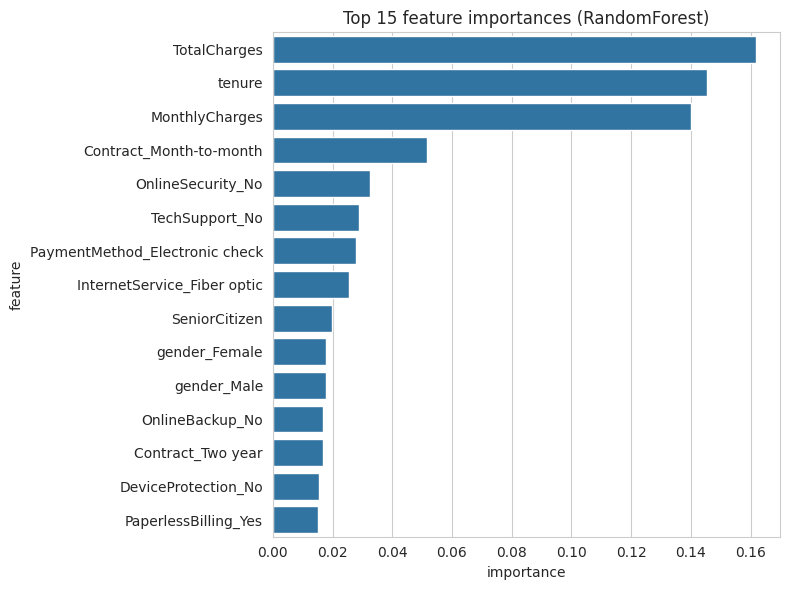

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df.head(15))
plt.title("Top 15 feature importances (RandomForest)")
plt.tight_layout()
plt.show()


In [50]:
# Use shap TreeExplainer on the trained rf (or on your chosen tree-based classifier in final_pipeline)
explainer = shap.TreeExplainer(rf)  # works for tree models
# Note: shap expects a 2D array; we pass X_trans (dense)
shap_values = explainer.shap_values(X_trans)  # for binary classification, shap_values[1] corresponds to positive class

# summary plot (global importance)
shap.summary_plot(shap_values, X_trans, feature_names=feature_names, plot_type="bar", max_display=15)


KeyboardInterrupt: 

In [ ]:
# explain first sample
sample_idx = 0
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][sample_idx], feature_names=feature_names)


In [ ]:
from scipy.stats import randint, uniform

# Example tuning for RandomForest
param_dist = {
    'clf__n_estimators': randint(50, 300),
    'clf__max_depth': randint(3, 15),
    'clf__min_samples_split': randint(2, 15)
}

# Build pipeline with RF
pipeline_rf = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

rand_search = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_dist,
    n_iter=25,                  # number of parameter settings sampled
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

rand_search.fit(X, y)
print("Best params:", rand_search.best_params_)
print("Best AUC:", rand_search.best_score_)


In [ ]:
# Suppose rand_search is best; otherwise use final_pipeline from step 9
best_pipeline = rand_search.best_estimator_ if 'rand_search' in globals() else final_pipeline

joblib.dump(best_pipeline, "best_churn_pipeline.pkl")
print("Saved best_churn_pipeline.pkl")


In [ ]:
loaded_pipeline = joblib.load("best_churn_pipeline.pkl")
# test on a sample
sample = X.iloc[[0]]  # take first row as example
print("Pred prob:", loaded_pipeline.predict_proba(sample)[0,1])
print("Pred label:", loaded_pipeline.predict(sample)[0])


In [ ]:
import gradio as gr

# load saved pipeline
pipeline = joblib.load("best_churn_pipeline.pkl")

# Build an input function that matches your model's needed raw features.
# For demo purposes, we'll create a simplified input with only a handful of features.
# In practice, you should include ALL features your pipeline expects.

def predict_demo(gender, seniorcitizen, tenure, monthlycharges, contract):
    # Build dataframe with one row and exact columns as original X
    row = X.iloc[[0]].copy()  # template row to get columns
    # set default values
    for col in row.columns:
        row.iloc[0][col] = 0

    # fill user inputs (you must map categories properly to original categorical values)
    row['gender'] = gender
    row['SeniorCitizen'] = int(seniorcitizen)
    row['tenure'] = float(tenure)
    row['MonthlyCharges'] = float(monthlycharges)
    row['Contract'] = contract

    proba = pipeline.predict_proba(row)[0,1]
    return f"Churn probability: {proba:.3f}"

demo = gr.Interface(
    fn=predict_demo,
    inputs=[
        gr.Radio(["Male", "Female"], label="gender"),
        gr.Radio([0,1], label="SeniorCitizen"),
        gr.Slider(0,72, value=10, label="tenure"),
        gr.Number(label="MonthlyCharges"),
        gr.Radio(["Month-to-month","One year","Two year"], label="Contract")
    ],
    outputs="text",
    title="Telco Churn Demo (simplified inputs)"
)

demo.launch(share=True)


In [ ]:
# app.py
import streamlit as st
import joblib
import pandas as pd
import numpy as np

st.title("Customer Churn Predictor")

pipeline = joblib.load("best_churn_pipeline.pkl")

st.markdown("Enter customer information:")

# Minimal inputs - expand to match your dataset
gender = st.selectbox("Gender", ["Male","Female"])
senior = st.selectbox("Senior Citizen", [0,1])
tenure = st.number_input("Tenure (months)", min_value=0, max_value=100, value=10)
monthly = st.number_input("MonthlyCharges", min_value=0.0, value=70.0)
contract = st.selectbox("Contract", ["Month-to-month","One year","Two year"])

if st.button("Predict"):
    # Build row in same columns as X
    row = X.iloc[[0]].copy()
    for col in row.columns:
        row.iloc[0][col] = 0
    row['gender'] = gender
    row['SeniorCitizen'] = int(senior)
    row['tenure'] = float(tenure)
    row['MonthlyCharges'] = float(monthly)
    row['Contract'] = contract

    proba = pipeline.predict_proba(row)[0,1]
    st.success(f"Churn probability: {proba:.3f}")
